In [3]:
import plotly
import numpy as np
import pandas as pd
from os import path
from utils import *
import seaborn as sns
import plotly.express as px
from calendar import monthrange
from fuzzywuzzy import fuzz, process
from matplotlib import pyplot as plt
from IPython.display import IFrame
# from fastprogress import progress_bar
from datetime import datetime, timedelta
from matplotlib.ticker import StrMethodFormatter

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [4]:
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

In [3]:
if not os.path.isfile('data_file.csv'):
    schemas = rq('SELECT schema_name FROM information_schema.schemata')
    schemas = list(schemas.schema_name)

    not_necessary_schemas = ['pg_toast', 'pg_temp_1', 'pg_toast_temp_1', 'pg_catalog', 'public', 'information_schema',
     'test', 'audittable', 'claimbook_group_of_hospitals', 'cb_report', 'mtdm', 'vikram']
    hosp_schemas = [schema_  for schema_ in schemas if schema_ not in not_necessary_schemas]

    with open('preauth_query_v2.sql','r') as query_file:
        unformatted_query = query_file.read()

    data = pd.DataFrame()
    for hosp_name in progress_bar(hosp_schemas, leave=False):
        exec_sql_str_test = unformatted_query.format(hospital=hosp_name)
        an_hosp_data = rq(exec_sql_str_test)
        data = pd.concat([data, an_hosp_data])
    data.to_csv('data_file.csv',index=False)
else:
    data = pd.read_csv('data_file.csv', infer_datetime_format=True)

In [4]:
data['target_exist'] = data.tpa_paid_amount.notna()

In [5]:
drop_list = ['al_number', 'final_bill_number', 'forwarded_to_claims_date', 'mrn', 'first_name',
          'insurance_policy_number', 'tpa_member_id', 'pincode', 'address_line1']

In [6]:
def get_person_age(row):
    recorded_age = row.loc['age']
    row = row.fillna(0)
    try:
        years_in_days = timedelta(row.loc['birth_of_year']*365)
        months_in_days = timedelta(row.loc['birth_of_month']*30)
        trailing_days = timedelta(row.loc['birth_of_day'])
        calculated_age = (years_in_days+months_in_days+trailing_days).days/365
        return pd.np.nan if calculated_age == 0 and recorded_age != 0  else calculated_age
    except TypeError:
        return pd.np.nan if recorded_age == 0 else recorded_age

def patient_age_buckets(age):
    if age > 65: ret_val = 'Old (65+)'
    elif age > 40: ret_val = 'Elder (40-65)'
    elif age > 20: ret_val = 'Adult (20-40)'
    elif age > 12: ret_val = 'Teen (12-20)'
    elif age > 3: ret_val = 'Child (3-12)'
    elif age > 0: ret_val = 'Infant (0-3)'
    else: ret_val = pd.np.nan
    return ret_val

In [7]:
data['patient_age'] = data.apply(lambda row: get_person_age(row),axis=1)
drop_list.extend(['age', 'birth_of_year','birth_of_month', 'birth_of_day' ])

In [8]:
data = data.drop(drop_list, axis=1)

In [9]:
def shorten_frame(frame, to_width=5, category_col='hospital_name'):
    tail_frame = frame.tail(frame.shape[0]-to_width)
    numeric_cols = frame.columns.to_list()
    numeric_cols.remove(category_col)
    last_row = ["Others"]
    for col in numeric_cols:
        last_row.append(tail_frame[col].sum())
    last_row_df= pd.DataFrame(last_row).T
    last_row_df.columns = frame.columns
    return pd.concat([frame.iloc[:to_width], last_row_df],ignore_index=True)

In [10]:
schema_grpby = data.groupby('hospital_name')
data_to_plot = []
for hosp_name, hosp_df in schema_grpby:
    hosp_info_tuple = (hosp_name, hosp_df.shape[0], 
                       hosp_df[hosp_df.is_forwarded_to_claims == True].shape[0], 
                       hosp_df.target_exist.sum())
    data_to_plot.append(hosp_info_tuple)

In [11]:
claims_plot_frame = pd.DataFrame(data_to_plot,columns=['hospital_name', 'Preauths Closed', 'Claims Forwarded', 'Claims Approved/FullyPaid'])\
    .sort_values(by='Preauths Closed',ascending=False)

In [12]:
short_frame = shorten_frame(claims_plot_frame,to_width=7)

## Analysis of Claimbook DB for Fintech

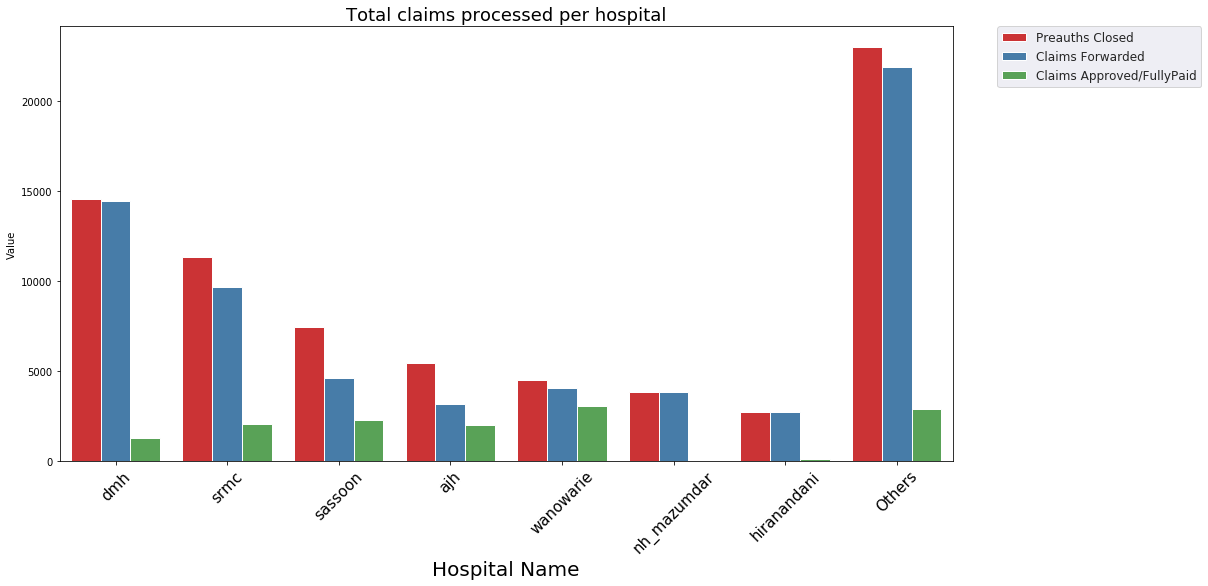

In [13]:
fig, ax1 = plt.subplots(figsize=(16,8 ))
tidy_df = short_frame.melt(id_vars='hospital_name').rename(columns=str.title)
sns.set(font_scale=1.1)
barplot = sns.barplot(x='Hospital_Name', y='Value', hue='Variable', data=tidy_df, ax=ax1,palette='Set1')
ax1.set_title('Total claims processed per hospital',fontsize=18)
# for p in barplot.patches:
#     barplot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
#                      ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=12, rotation=25)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45, fontsize=15)
plt.xlabel('Hospital Name',fontsize=20)
plt.show()

In [14]:
data = data[data.is_forwarded_to_claims == True]

In [15]:
approved_claims = data[data.target_exist==True]
pending_claims = data[data.target_exist==False]

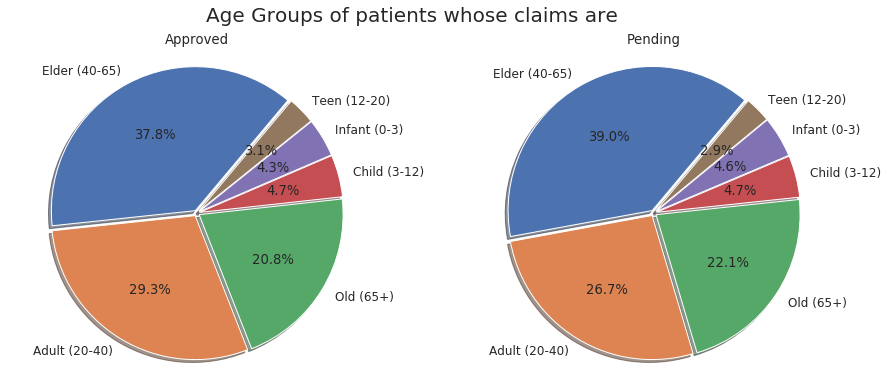

In [16]:
fig, axes = plt.subplots(figsize=(15,6),ncols=2)
axes = axes.flatten()
for i, target in enumerate(sorted(data.target_exist.unique(),reverse=True)):
    data_subset = data[data.target_exist == target]
    chart_values = data_subset.patient_age.apply(patient_age_buckets).value_counts()
    labels = chart_values.index.values 
    sizes = chart_values.values
    explode = [0.02]*labels.shape[0]

    axes[i].pie(sizes, explode=explode,labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=50)
    axes[i].axis('equal')
    title_func = lambda x: "Approved" if x ==True else "Pending"
    axes[i].set_title(title_func(target))
fig.suptitle('Age Groups of patients whose claims are',fontsize=20)
plt.show()

In [17]:
data.gender.replace(['Female ','F'],'Female', inplace=True)
data.gender.replace(['M','Other'],'Male',inplace=True)

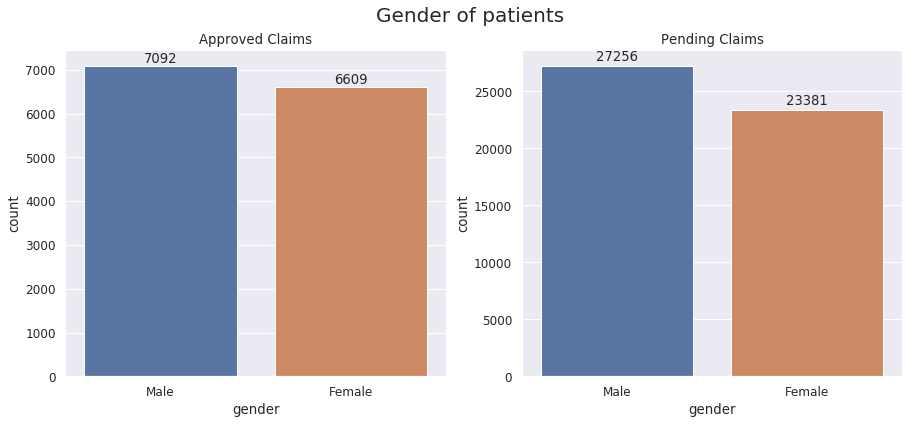

In [18]:
fig, axes = plt.subplots(figsize=(15,6),ncols=2)
axes = axes.flatten()
title_func = lambda x: "Approved Claims" if x ==True else "Pending Claims"
for i, target in enumerate(sorted(data.target_exist.unique(),reverse=True)):
    data_subset = data[data.target_exist == target]
    plot_fig = sns.countplot(data_subset.gender,ax=axes[i])
    for p in plot_fig.patches:
        plot_fig.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()-60), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points',)
    axes[i].set_title(title_func(target))
fig.suptitle('Gender of patients',fontsize=20)
plt.show()

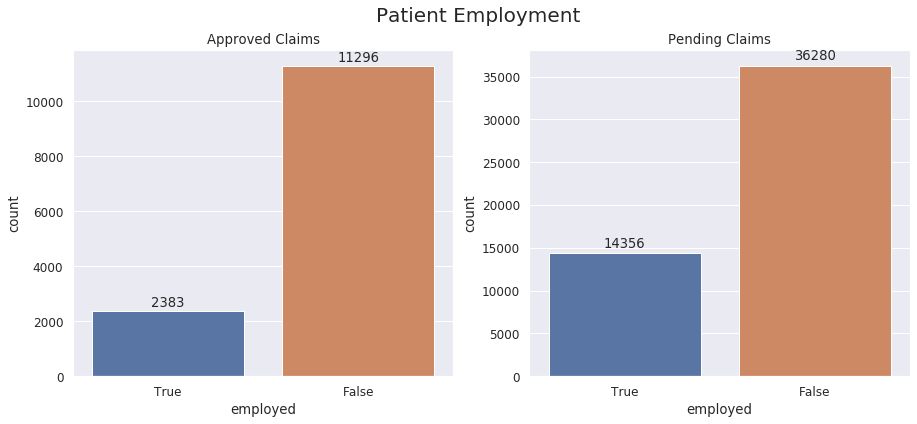

In [19]:
fig, axes = plt.subplots(figsize=(15,6),ncols=2)
axes = axes.flatten()
bars_order = sorted(data.employed.value_counts().index.values.tolist(),reverse=True)
title_func = lambda x: "Approved Claims" if x ==True else "Pending Claims"
for i, target in enumerate(sorted(data.target_exist.unique(),reverse=True)):
    data_subset = data[data.target_exist == target]
    plot_fig = sns.countplot(x='employed', data=data_subset,ax=axes[i], order=bars_order)
    for p in plot_fig.patches:
        plot_fig.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()-60), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points',)
    axes[i].set_title(title_func(target))
fig.suptitle('Patient Employment',fontsize=20)
plt.show()

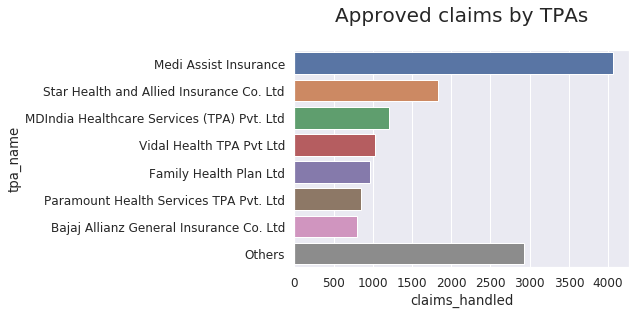

In [20]:
tpa_name_series = approved_claims.tpa_name.value_counts()
tpa_df = pd.DataFrame({'tpa_name':tpa_name_series.index.values, 'claims_handled': tpa_name_series.values})
short_tpa_df = shorten_frame(tpa_df, category_col='tpa_name', to_width=7)

barplot = sns.barplot(y='tpa_name', x='claims_handled',data = short_tpa_df)
plt.title('Approved claims by TPAs\n',fontsize=20)
plt.show()

In [21]:
def get_leaked_revenue(row):
    actual_amnt = row['actualcosthospitalization']
    tpa_amnt = row['tpa_paid_amount']
    patient_amnt = row['patient_paid_amount']
    if patient_amnt is None:  patient_amnt = 0
    return (actual_amnt - (tpa_amnt + patient_amnt))

In [22]:
## claims completely closed
closed_claims = approved_claims[approved_claims.claim_closed == True]
closed_claims['leaked_revenue'] = closed_claims.apply(get_leaked_revenue, axis=1)

closed_claims = closed_claims[closed_claims.dateofadmission != '0019-11-05']
closed_claims['dateofadmission']=closed_claims.dateofadmission.apply(lambda x: pd.to_datetime(x).date())
closed_claims['dateofdischarge']=closed_claims.dateofdischarge.apply(lambda x: pd.to_datetime(x).date())
# closed_claims[closed_claims['leaked_revenue'] < 3e6)

In [23]:
preprocess_date1 = lambda adate: datetime(2019, adate.month, adate.day) if adate.year > 2019 else adate
preprocess_date2 = lambda adate: datetime(2017, adate.month, adate.day) if adate.year < 2017 else adate
closed_claims.dateofadmission = closed_claims.dateofadmission.apply(preprocess_date1)
closed_claims.dateofadmission = closed_claims.dateofadmission.apply(preprocess_date2)

closed_claims.dateofdischarge = closed_claims.apply(lambda row: \
                            row['dateofadmission']+timedelta(days=row['stayindays']),axis=1)
closed_claims.dateofdischarge = closed_claims.dateofdischarge.apply(preprocess_date1)
closed_claims.dateofdischarge = closed_claims.dateofdischarge.apply(preprocess_date2)

In [24]:
closed_claims['discharged_year'] = closed_claims.dateofdischarge.apply(lambda x: x.year)
closed_claims['discharged_month'] = closed_claims.dateofdischarge.apply(lambda x: x.month)
closed_claims['discharged_day'] = closed_claims.dateofdischarge.apply(lambda x: x.day)

#claims with a  parsed transaction date from settlement letter
claims_with_trnxn_dates = closed_claims[closed_claims.tpa_transaction_date.notna()]

In [25]:
# approved_data[['claim_id','hospital_name','actualcosthospitalization','patientresponsibility',
#                'patientdiscount','patientpayable','tpa_paid_amount','patient_paid_amount']].sample(5)

In [26]:
money_lost = closed_claims[closed_claims.leaked_revenue >= 0]
money_excess = closed_claims[closed_claims.leaked_revenue < 0]

In [27]:
money_lost_outlier_mask = money_lost['leaked_revenue'].apply(lambda money: True if money > 3e6 else False)
money_lost_outliers = money_lost[money_lost_outlier_mask]
money_lost = money_lost[~money_lost_outlier_mask]

In [28]:
hosp_names = closed_claims.hospital_name.unique()
lost_money, excess_money= [], []
for hosp in hosp_names:
    lost_money.append(round(money_lost[money_lost.hospital_name == hosp]['leaked_revenue'].sum(),2))
    excess_money.append(abs(round(money_excess[money_excess.hospital_name == hosp]['leaked_revenue'].sum(),2)))
revenue_details = pd.DataFrame([hosp_names,lost_money,excess_money]).T
revenue_details.columns = ['hospital_name', 'money_lost', 'money_excess']
revenue_details.sort_values(by='money_lost',ascending=False,inplace=True)

In [29]:
short_revenue_frame = shorten_frame(revenue_details,category_col='hospital_name',to_width=6)
# short_revenue_frame.style.format({'money_lost':' {:12.0f}', 'money_excess': '{:12.0f}'})

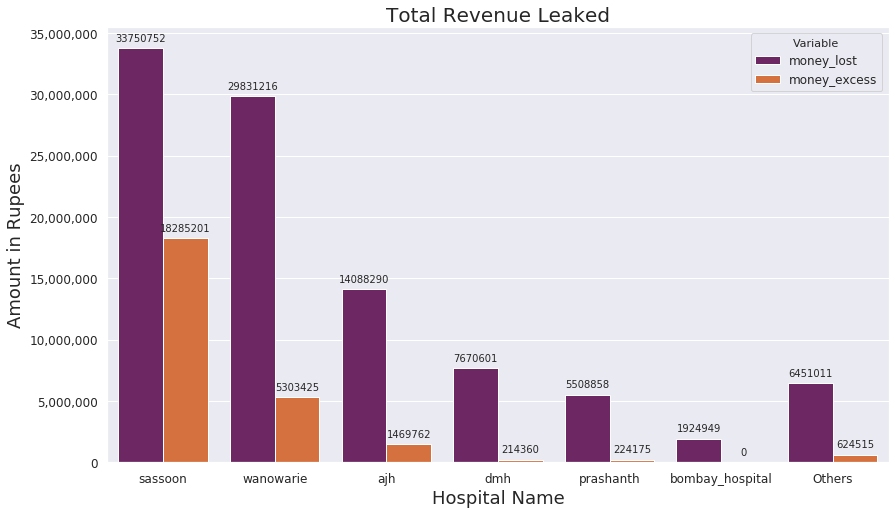

In [30]:
fig, ax1 = plt.subplots(figsize=(14,8))
tidy_revenue_df = short_revenue_frame.melt(id_vars='hospital_name').rename(columns=str.title)
rvnu_barplot = sns.barplot(x='Hospital_Name', y='Value', hue='Variable', data=tidy_revenue_df, ax=ax1,palette='inferno')
for p in rvnu_barplot.patches:
    rvnu_barplot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=10)
ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Hospital Name',fontsize=18)
plt.ylabel('Amount in Rupees', fontsize=18)
plt.title('Total Revenue Leaked', fontsize=20)
plt.show()

###### Few Outliers based on final bill amount

In [31]:
money_lost_outliers[['hospital_name','gender','diagnosis_description','stayindays',\
                    'actualcosthospitalization','tpa_paid_amount','patient_paid_amount',\
                    'leaked_revenue']].style.format({'actualcosthospitalization':'{:12.0f}', 'leaked_revenue':'{:12.0f}'})

,hospital_name,gender,diagnosis_description,stayindays,actualcosthospitalization,tpa_paid_amount,patient_paid_amount,leaked_revenue
40218,prashanth_chetpet,Female,ACUTE GASTROENTERITIS,2,19106697,9143,12768,19084786
40385,prashanth_chetpet,Female,31/P2L2/PREV 2 LSCS / CERVICAL FIBROID,2,19112130,84114,17235,19010781
68047,wanowarie,Male,FEVER,4,3971445,13453,40221,3917771
70010,wanowarie,Male,ACCELERATED HTN,2,97822857,15457,0,97807400


In [32]:
revenue_grouped_df = money_lost[['hospital_name', 'leaked_revenue','discharged_year', 'discharged_month']].\
        groupby(['hospital_name','discharged_year','discharged_month']).sum()
# revenue_grouped_df.style.format({'leaked_revenue':' {:12.0f}'})

In [33]:
revenue_grouped_df.reset_index(inplace=True)

In [34]:
def make_date(yr,month):
    return datetime(yr,month, monthrange(yr,month)[1])

In [35]:
revenue_grouped_df['date'] = revenue_grouped_df.apply(lambda row: \
                                make_date(row['discharged_year'], row['discharged_month']),axis=1)

In [36]:
top_revenue_leaked_hospitals= short_revenue_frame.hospital_name[:-1].to_list()
top_rvnue_leaked_hosp_mask = revenue_grouped_df.hospital_name.apply(lambda h_name: True if
                                        h_name in top_revenue_leaked_hospitals else False)

In [37]:
fig = go.Figure()
for hosp in top_revenue_leaked_hospitals:
    hosp_df = revenue_grouped_df[revenue_grouped_df.hospital_name==hosp]
    fig.add_trace(go.Scatter(x=hosp_df.date, y=hosp_df.leaked_revenue, mode='lines+markers', name=hosp))

other_hosp_rvnue_leak = revenue_grouped_df[~top_rvnue_leaked_hosp_mask].\
                groupby(['discharged_year','discharged_month']).sum()
other_hosp_rvnue_leak.reset_index(inplace=True)
other_hosp_rvnue_leak['date']=other_hosp_rvnue_leak.apply(lambda row: \
                make_date(row['discharged_year'].astype(int), row['discharged_month'].astype(int)), axis=1)
fig.add_trace(go.Scatter(x=other_hosp_rvnue_leak.date, y=other_hosp_rvnue_leak.leaked_revenue,
                mode='lines+markers', name='Other Hospitals'))
fig.update_layout(title='Total Revenue Leakage timeline per hospital',
                xaxis_title='Timeline (Monthly)',
                yaxis_title='Amount in Rupees')
plotly.offline.plot(fig, filename='revenue_leak_timeline.html',auto_open=False)
# fig.show()
print()

In [38]:
IFrame(src='revenue_leak_timeline.html', width=980, height=550)

### Doctors and revenue

In [39]:
doc_revenue_df = money_lost[['hospital_name','treatment_doctor_id','leaked_revenue']]
doc_revenue_df['treated_cases'] = 1
doc_revenue_groupby = doc_revenue_df.groupby(['hospital_name', 'treatment_doctor_id'])[['leaked_revenue','treated_cases']].sum()
doc_revenue_groupby.reset_index(inplace=True)

In [40]:
aj_doc_df = doc_revenue_groupby[doc_revenue_groupby.hospital_name == 'ajh'].sort_values(by=['leaked_revenue'], ascending=False)

In [41]:
aj_doc_df.head()

,hospital_name,treatment_doctor_id,leaked_revenue,treated_cases
72,ajh,Dr. Purushotham R.,1137915.00,43
50,ajh,Dr. Manjunath B.V,948907.87,46
68,ajh,Dr. Praveen J Shetty,925044.00,39
99,ajh,Dr. Shiva Shankar Bhat,748527.00,31
32,ajh,Dr. E.V.S Maben,655515.10,55


### Fuzzy Matching doctor names

In [42]:
doctors_list_lower = [doc_name.lower().lstrip('[dr\. ]') for doc_name in aj_doc_df.treatment_doctor_id.to_list()]

In [139]:
process.extract('Dr. Purushotham R.', aj_doc_df.treatment_doctor_id,scorer=fuzz.partial_token_sort_ratio)

[('Dr. Purushotham R.', 100, 72),
 ('Dr. Purushotham R', 100, 71),
 ('Dr. Pritam Sharma', 62, 70),
 ('Dr. Prashanth Shetty', 62, 67),
 ('Dr. Vishwanth', 58, 130)]

In [140]:
process.extract('Dr. Manjunath B.V', aj_doc_df.treatment_doctor_id,scorer=fuzz.partial_token_sort_ratio)

[('Dr. Manjunath B.V', 100, 50),
 ('b v manjunath', 92, 139),
 ('Dr. MANJUNATH KAMATH', 67, 48),
 ('Dr. Vishwanath', 62, 129),
 ('Dr. Sanath Bhandary N', 60, 92)]

### Time taken for full pay

In [44]:
claims_with_trnxn_dates['time_taken']=claims_with_trnxn_dates[['dateofdischarge','tpa_transaction_date']]\
                .apply(lambda row: (row['tpa_transaction_date'].date() - row['dateofdischarge'].date()).days,axis=1)

In [45]:
not_usable_claims = claims_with_trnxn_dates[claims_with_trnxn_dates.time_taken <= 0]
usable_claims = claims_with_trnxn_dates[claims_with_trnxn_dates.time_taken > 0]

In [46]:
# not_usable_claims[['dateofadmission','created_date_time', 'dateofdischarge','tpa_transaction_date']]

In [55]:
# usable_claims.shape, not_usable_claims.shape

In [127]:
def binning_time_buckets(days):
    bin_val = ''
    if days > 0 and days <= 15: bin_val =  '0 - 15 days'
    elif days > 15 and days <= 30: bin_val = '15 - 30 days'
    elif days > 30 and days <= 60: bin_val = '30 - 60 days'
    elif days > 60 and days <= 100: bin_val = '60 - 100 days'
    elif days > 100 and days <= 200: bin_val = '100 - 200 days'
    else: bin_val = 'above 200 days'
    return bin_val

In [128]:
usable_claims['stayindays'] = usable_claims.apply(lambda row: abs((row['dateofdischarge'].date() - row['dateofadmission']).days),axis=1)

In [131]:
usable_claims['time_bucket'] = usable_claims.time_taken.apply(binning_time_buckets)
order = [ '0 - 15 days', '15 - 30 days','30 - 60 days', '60 - 100 days', '100 - 200 days', 'above 200 days']
order_2 = [ '0 - 25 days', '25 - 50 days','50 - 100 days', '100 - 150 days', '150 - 200 days', 'above 200 days']

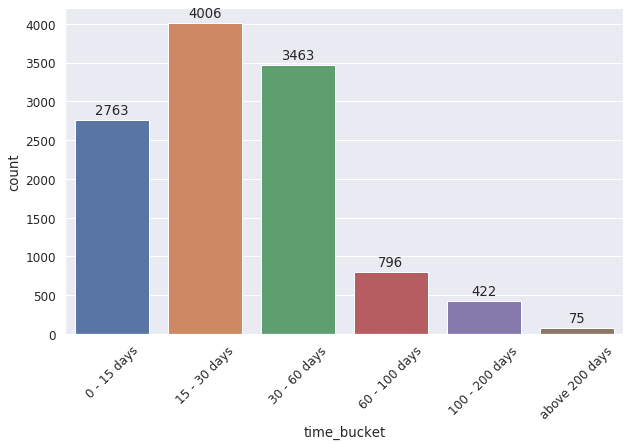

In [132]:
fig,ax = plt.subplots(figsize=(10,6))
plot_fig = sns.countplot(usable_claims.time_bucket,order=order)
for p in plot_fig.patches:
    plot_fig.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points',)
plt.xticks(rotation=45)
plt.show()

### Outliers in data (by cost)

In [133]:
top_claim_acc_hosp_thresh = 5
top_claim_acc_hosp_names = claims_plot_frame.sort_values(by='Claims Approved/FullyPaid',ascending=False)\
        .head(top_claim_acc_hosp_thresh)\
        .hospital_name.to_list()

mask = usable_claims.hospital_name.apply(lambda hname: True if hname in top_claim_acc_hosp_names else False)
top_hospitals_df = usable_claims[mask]

In [134]:
df = top_hospitals_df[top_hospitals_df.actualcosthospitalization > 10e5]
df[['hospital_name','diagnosis_description','department','treatment','stayindays','expectedcosthospitalization',
        'actualcosthospitalization']].sort_values(by='actualcosthospitalization',ascending=False).head(8)

,hospital_name,diagnosis_description,department,treatment,stayindays,expectedcosthospitalization,actualcosthospitalization
70010,wanowarie,ACCELERATED HTN,CARDIOLOGIST,MEDICAL_MANAGEMENT,2,27000.0,97822857.0
68876,wanowarie,PLATE REMOVAL,Other,SURGERY,2,75000.0,18189004.0
68047,wanowarie,FEVER,PHYSICIAN,NaN,4,44000.0,3971445.0
48369,sassoon,RT IC BLEED,Surgical & Medical,NaN,3,176300.0,2194774.0
45005,sassoon,BREATHNESS,Surgical & Medical,NaN,4,91500.0,2066733.0
46260,sassoon,RADIATION,Surgical & Medical,MEDICAL_MANAGEMENT,2,210000.0,1904287.0
45439,sassoon,PTCA,Other,NaN,2,158549.0,1900835.0
45287,sassoon,LT HAEMORRPHAGIC INFARCT,Other,MEDICAL_MANAGEMENT,22,395262.0,1876471.0


In [135]:
usable_claims[usable_claims.actualcosthospitalization < 25e5][['hospital_name','gender','diagnosis_description','stayindays','actualcosthospitalization','dateofdischarge']]\
                .sort_values('actualcosthospitalization',ascending=False).head(8)

,hospital_name,gender,diagnosis_description,stayindays,actualcosthospitalization,dateofdischarge
48369,sassoon,Male,RT IC BLEED,3,2194774.0,2019-05-18
45005,sassoon,Female,BREATHNESS,4,2066733.0,2018-12-27
5901,bombay_hospital,Male,ATTACHED,4,1909373.0,2019-08-15
46260,sassoon,Male,RADIATION,2,1904287.0,2019-02-20
45439,sassoon,Male,PTCA,2,1900835.0,2019-01-12
45287,sassoon,Female,LT HAEMORRPHAGIC INFARCT,22,1876471.0,2019-01-26
45496,sassoon,Male,MITRAWALVE,10,1874701.0,2019-02-01
44799,sassoon,Male,CTA,9,1827809.0,2018-12-22


In [141]:
toggle_code_button